# Chapter 4 Training Models

## Exercises
1. Which Linear Regression training algorithm can you use if you have a training set with millions of features?

- Untuk dataset dengan jutaan features, Anda harus menggunakan Gradient Descent (seperti Batch Gradient Descent, Stochastic Gradient Descent, atau Mini-batch Gradient Descent). Normal Equation tidak praktis karena memerlukan komputasi inversi matriks XᵀX yang berukuran n×n dimana n adalah jumlah features, yang memiliki kompleksitas O(n³). Dari kode yang saya lihat, implementasi SGD menggunakan SGDRegressor dari sklearn sangat efisien untuk dataset besar.

2. Suppose the features in your training set have very different scales. Which algorithms might suffer from this, and how? What can you do about it?

- Gradient Descent akan sangat menderita karena cost function menjadi berbentuk ellips memanjang, menyebabkan konvergensi lambat atau bahkan divergensi. Solusinya adalah melakukan feature scaling menggunakan StandardScaler. Dari contoh kode yang saya lihat, accuracy meningkat dari ~87% menjadi ~90% setelah scaling. Normal Equation tidak terpengaruh karena menghitung solusi langsung secara matematis.

3. Can Gradient Descent get stuck in a local minimum when training a Logistic Regression model?

- Tidak. Logistic Regression menggunakan log loss function yang bersifat convex (cembung). Function convex hanya memiliki satu global minimum dan tidak memiliki local minima. Jadi Gradient Descent dijamin akan menemukan global optimum, meskipun mungkin memerlukan waktu lama untuk konvergen.

4. Do all Gradient Descent algorithms lead to the same model, provided you let them run long enough?

- Tidak selalu. Batch Gradient Descent akan mencapai global minimum untuk convex problems. Namun Stochastic Gradient Descent dan Mini-batch Gradient Descent akan terus berfluktuasi di sekitar minimum karena noise dalam estimasi gradient. Mereka tidak akan benar-benar konvergen kecuali learning rate dikurangi secara bertahap (seperti dengan learning schedule dalam kode).

5. Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

- Kemungkinan learning rate terlalu besar, menyebabkan algorithm "melompat" melewati minimum dan divergen. Solusinya:
Kurangi learning rate
Implementasikan early stopping untuk menghentikan training saat validation error mulai meningkat
Gunakan adaptive learning rate atau learning rate scheduling

6. Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?

- Tidak. Mini-batch Gradient Descent menggunakan subset data yang berbeda setiap batch, sehingga validation error akan berfluktuasi naik-turun. Kenaikan sesekali adalah normal. Sebaiknya gunakan patience - hentikan hanya setelah beberapa epoch berturut-turut tanpa perbaikan, atau gunakan moving average untuk validation error.

7. Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?

- Stochastic Gradient Descent paling cepat mencapai vicinity of optimal solution karena update parameter setiap sample
Batch Gradient Descent yang benar-benar konvergen ke optimum
Untuk membuat SGD dan Mini-batch GD konvergen: gunakan learning rate schedule yang menurun seiring waktu (seperti learning_schedule dalam kode)

8. Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

- Ini menandakan overfitting. Model terlalu kompleks untuk data yang tersedia. Tiga solusi:
- Regularization - gunakan Ridge, Lasso, atau Elastic Net regression
- Kurangi degree polynomial - model lebih sederhana
- Tambah data training - lebih banyak data untuk model kompleks

9. Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?

- Model menderita high bias (underfitting). Training dan validation error yang hampir sama menunjukkan model terlalu sederhana. Anda harus menurunkan α (regularization parameter) untuk mengurangi regularization dan membuat model lebih kompleks.

10. Why would you want to use:
    - a. Ridge Regression instead of plain Linear Regression (i.e., without any regularization)?
    - Untuk mencegah overfitting terutama ketika features lebih banyak dari samples atau ada multicollinearity. Ridge menambah L2 penalty.
    - b. Lasso instead of Ridge Regression?
    - Feature selection otomatis - Lasso dapat menghasilkan sparse solutions (coefficients = 0), efektif mengeliminasi features yang tidak penting.
    - c. Elastic Net instead of Lasso?
    - Stabilitas - ketika ada grup features yang berkorelasi, Lasso cenderung memilih satu secara acak. Elastic Net (kombinasi L1+L2) memilih seluruh grup.

11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?
- Dua Logistic Regression classifiers terpisah karena ini adalah multi-label classification problem. Setiap gambar dapat memiliki label independen (outdoor+daytime, indoor+nighttime, dll.). Softmax digunakan untuk multi-class problems dimana classes mutually exclusive.

In [466]:
import numpy as np

np.random.seed(42)

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Di atas generate data

In [467]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

Mencari theta

In [468]:
theta_best

array([[4.21509616],
       [2.77011339]])

Prediksi degnan theta

In [469]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

In [470]:
import matplotlib.pyplot as plt

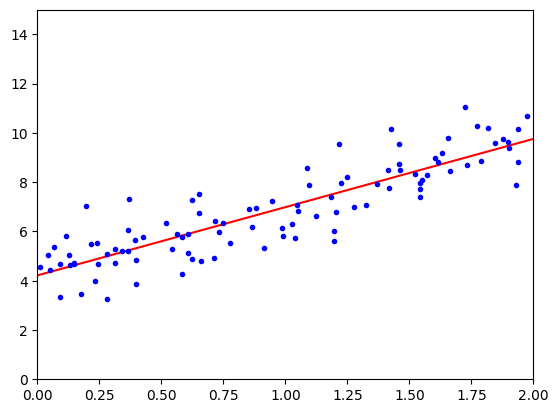

In [471]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [472]:
from sklearn.linear_model import LinearRegression

In [473]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [474]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [475]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

### Batch Gradient Descent

In [476]:
eta = 0.1
n_iterations = 1000
m = 100

In [477]:
theta = np.random.randn(2,1)

In [478]:
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [479]:
theta

array([[4.21509616],
       [2.77011339]])

### Stochastic Gradient Descent

In [480]:
n_epochs = 50
t0, t1 = 5, 50

In [481]:
def learning_schedule(t):
    return t0 / (t + t1)

In [482]:
theta = np.random.randn(2,1)

In [483]:
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [484]:
theta

array([[4.18475289],
       [2.73036719]])

### Polynomial Regression

In [485]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [486]:
from sklearn.preprocessing import PolynomialFeatures

In [487]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [488]:
X[0]

array([0.48570228])

In [489]:
X_poly[0]

array([0.48570228, 0.2359067 ])

In [490]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.8699327]), array([[0.99763195, 0.51104433]]))

### Learning Curves

In [491]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [492]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

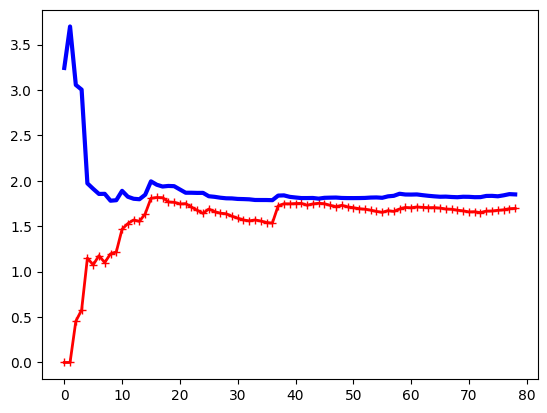

In [493]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

In [494]:
from sklearn.pipeline import Pipeline

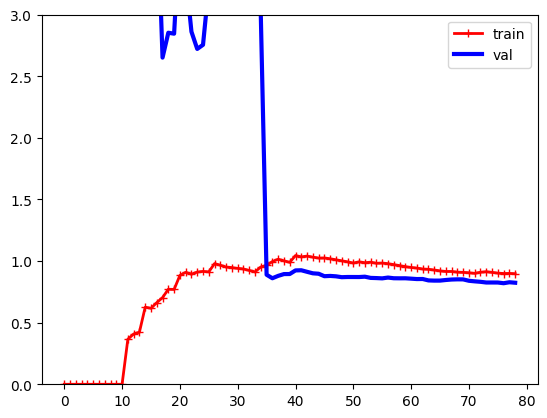

In [495]:
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])
plot_learning_curves(polynomial_regression, X, y)
plt.ylim([0, 3])
plt.legend()

### Ridge Regression

In [499]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor

In [500]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([5.17154312])

In [501]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.0001)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([3.62621896])

### Lasso Regression

In [502]:
from sklearn.linear_model import Lasso

In [503]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.13721011])

### Elastic Net

In [504]:
from sklearn.linear_model import ElasticNet

In [505]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.13588066])

### Decision Boundaries

In [508]:
from sklearn import datasets


In [509]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [511]:
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(int)

In [512]:
from sklearn.linear_model import LogisticRegression

In [513]:
log_reg = LogisticRegression()
log_reg.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


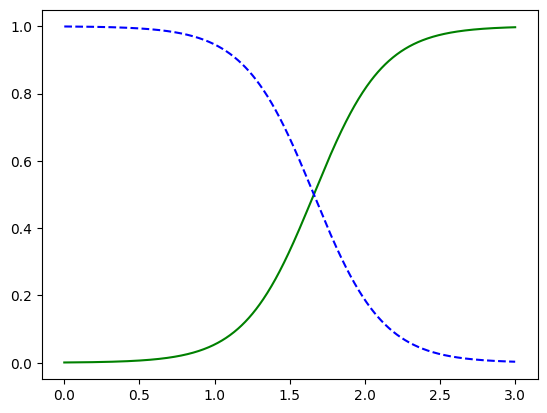

In [514]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")

In [515]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])